# Chaper 2 - N-armed Bandits
### Deep Reinforcement Learning _in Action_

##### Listing 2.1

In [1]:
def get_best_action(actions):
	best_action = 0
	max_action_value = 0
	for i in range(len(actions)): #A 
		cur_action_value = get_action_value(actions[i]) #B
		if cur_action_value > max_action_value:
			best_action = i
			max_action_value = cur_action_value
	return best_action

##### Listing 2.2

In [17]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

n = 10
probs = np.random.rand(n) #A
eps = 0.1

##### Listing 2.3

In [18]:
def get_reward(prob, n=10):
    reward = 0;
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

In [19]:
reward_test = [get_reward(0.7) for _ in range(2000)]

In [20]:
np.mean(reward_test)

7.0065

In [21]:
sum = 0
x = [4,5,6,7]
for j in range(len(x)): 
	sum = sum + x[j]
sum

22

(array([  2.,   5.,  10.,  64., 221., 397., 535., 467., 299.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 9 Patch objects>)

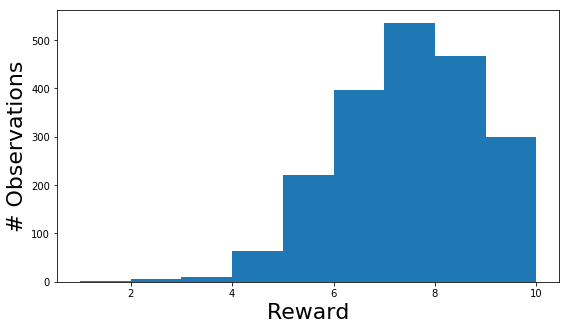

In [22]:
plt.figure(figsize=(9,5))
plt.xlabel("Reward",fontsize=22)
plt.ylabel("# Observations",fontsize=22)
plt.hist(reward_test,bins=9)

##### Listing 2.4

In [23]:
# 10 actions x 2 columns
# Columns: Count #, Avg Reward
record = np.zeros((n,2))

In [24]:
def get_best_arm(record):
    arm_index = np.argmax(record[:,1],axis=0)
    return arm_index

In [25]:
def update_record(record,action,r):
    # col_0: the number of times each arm has been pulled
    # col_1: the average reward
    new_r = (record[action,0] * record[action,1] + r) / (record[action,0] + 1)
    record[action,0] += 1
    record[action,1] = new_r
    return record

##### Listing 2.5

<BarContainer object of 10 artists>

[0.31034961 0.73989198 0.33166471 0.71433313 0.91331369 0.05331487
 0.67974816 0.42438542 0.61011223 0.55613677]
[[8.00000000e+00 2.50000000e+00]
 [1.00000000e+01 8.00000000e+00]
 [6.00000000e+00 3.00000000e+00]
 [2.10000000e+01 6.76190476e+00]
 [3.94000000e+02 9.19796954e+00]
 [7.00000000e+00 2.85714286e-01]
 [1.50000000e+01 6.80000000e+00]
 [1.10000000e+01 4.63636364e+00]
 [1.10000000e+01 6.54545455e+00]
 [1.70000000e+01 5.52941176e+00]]


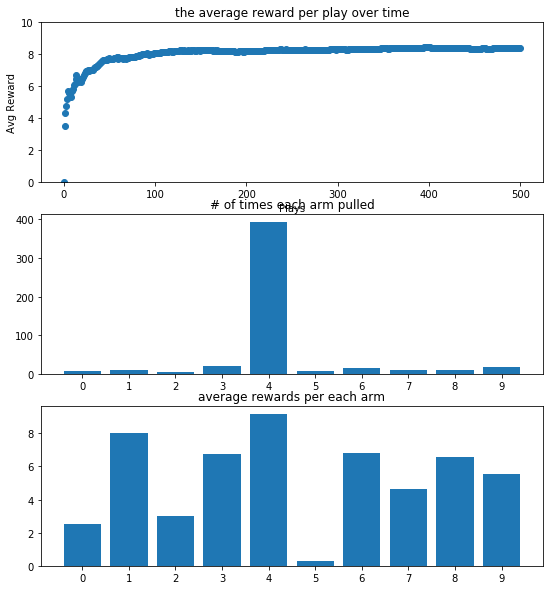

In [141]:
fig,ax = plt.subplots(3,1)
ax[0].set_xlabel("Plays")
ax[0].set_ylabel("Avg Reward")
fig.set_size_inches(9,10)

n = 10
record = np.zeros((n, 2))
probs = np.random.rand(n)
eps = 0.2     # e-greedy exploration param
rewards = [0]

for i in range(500):
    if random.random() > eps:
        choice = get_best_arm(record)   # exploit: choose the best arm
    else:  # or explore
        choice = np.random.randint(10)
    r = get_reward(probs[choice])                  # computes the reward for choosing the arm
    record = update_record(record,choice,r)        # updates the record
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)  # tracks the running average of rewards
    rewards.append(mean_reward)
ax[0].scatter(np.arange(len(rewards)),rewards)
ax[0].set_ylim(0, 10)

ax[1].bar([str(x) for x in range(n)], record[:,0])
ax[2].bar([str(x) for x in range(n)], record[:,1])

ax[0].set_title("the average reward per play over time")
ax[1].set_title("# of times each arm pulled")
ax[2].set_title("average rewards per each arm")
print(probs)  # probability of getting reward (+1) per each arm
print(record)

##### Listing 2.6

In [142]:
# using softmax policy instead of e-greedy: use probability distribution of options
def softmax(av, tau=1.12):
    softm = ( np.exp(av / tau) / np.sum( np.exp(av / tau) ) )
    return softm

In [151]:
probs = np.random.rand(n)
record = np.zeros((n,2))

In [153]:
softmax(record[:,1], tau=0.7)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

[0.49893431 0.9086811  0.92658049 0.91978463 0.16695137 0.36834375
 0.89148077 0.88640245 0.34925965 0.71609211]
[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 18.           9.05555556]
 [  0.           0.        ]
 [  0.           0.        ]
 [468.           8.96153846]
 [  0.           0.        ]
 [ 14.           4.35714286]
 [  0.           0.        ]]


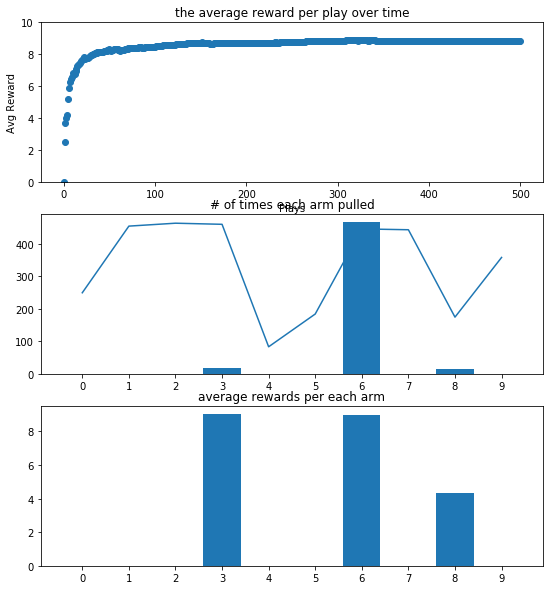

In [191]:
fig,ax = plt.subplots(3,1)
ax[0].set_xlabel("Plays")
ax[0].set_ylabel("Avg Reward")
fig.set_size_inches(9,10)

n = 10
record = np.zeros((n, 2))
probs = np.random.rand(n)

rewards = [0]
no_iter = 500

for i in range(no_iter):
    p = softmax(record[:,1],tau=1.2)
#     print(p)
    choice = np.random.choice(np.arange(n),p=p)
    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)

ax[0].scatter(np.arange(len(rewards)),rewards)
ax[0].set_ylim(0, 10)

ax[0].set_title("the average reward per play over time")
ax[1].set_title("# of times each arm pulled")
ax[2].set_title("average rewards per each arm")

ax[1].bar([str(x) for x in range(n)], record[:,0])
ax[1].plot([str(x) for x in range(n)], probs*no_iter) # reward probability; if ideal = them algorithm should select an arm with higher reward prob. 
ax[2].bar([str(x) for x in range(n)], record[:,1])

print(probs)  # probability of getting reward (+1) per each arm
print(record)

##### Listing 2.9

In [199]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [203]:
import numpy as np
import torch

arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

In [319]:
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)
print(state)

8


In [320]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

In [321]:
loss_fn = torch.nn.MSELoss()

In [322]:
env = ContextBandit(arms)

In [323]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [324]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

In [325]:
def train(env, epochs=5000, learning_rate=1e-2):
    cur_state = torch.Tensor(one_hot(arms,env.get_state())) #A
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for i in range(epochs):
        y_pred = model(cur_state) #B
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0) #C
        av_softmax /= av_softmax.sum() #D
        choice = np.random.choice(arms, p=av_softmax) #E
        cur_reward = env.choose_arm(choice) #F
        one_hot_reward = y_pred.data.numpy().copy() #G
        one_hot_reward[choice] = cur_reward #H
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_state = torch.Tensor(one_hot(arms,env.get_state())) #I
    return np.array(rewards)

In [326]:
rewards = train(env)

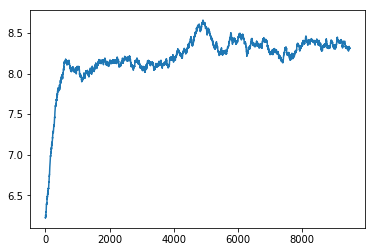

In [327]:
plt.plot(running_mean(rewards,N=500))